## **--- Library ---**

*--- Install ---*

In [1]:
!pip install -q transformers datasets scikit-learn imbalanced-learn tqdm

*--- Import ---*

In [2]:
import re
import random
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler, pipeline
from tqdm import tqdm
tqdm.pandas()

## **--- Load Dataset ---**

In [3]:
file_id = '1xpQp-GqED-iFzKol7_aL_qR49NpR-Bsl'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5383 entries, 0 to 5382
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   full_text                5382 non-null   object 
 1   username;;;              2776 non-null   object 
 2   conversation_id_str      2607 non-null   float64
 3   created_at               2607 non-null   object 
 4   favorite_count           2607 non-null   float64
 5   id_str                   2607 non-null   float64
 6   image_url                564 non-null    object 
 7   in_reply_to_screen_name  973 non-null    object 
 8   lang                     2607 non-null   object 
 9   location                 0 non-null      float64
 10  quote_count              2607 non-null   float64
 11  reply_count              2607 non-null   float64
 12  retweet_count            2607 non-null   float64
 13  tweet_url                2607 non-null   object 
 14  user_id_str             

In [4]:
# Hanya mengambil kolom yang diperlukan
df = df[['full_text']]
df.head()

,full_text
0,Kl misal kritik pemerintah akan diframing seba...
1,Makin hari makin capek buka twitter ada aja be...
2,@ilhampid biarin EGP biar pemerintah +negara y...
3,@hammsqi Kalo dikejar-kejar karena kebebasan b...
4,Makanya susah kalo mau perubahan karena masyar...


In [5]:
# menghapus data duplikat dan null
df = df.dropna().drop_duplicates().reset_index(drop=True)
print(f"Data shape after cleaning: {df.shape}")

Data shape after cleaning: (4528, 1)


## **--- Data Preparation ---**

*--- Pre-Processing teks ---*

In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)  # Hapus URL
    text = re.sub(r'@\w+|#\w+', '', text)        # Hapus mention dan hashtag
    text = re.sub(r'\s+', ' ', text).strip()     # Hapus spasi ganda
    return text

df['cleaned_tweet'] = df['full_text'].apply(clean_text)

In [7]:
# perbandingan sebelum dan sesudah preprocessing teks
df[['full_text', 'cleaned_tweet']].head()

,full_text,cleaned_tweet
0,Kl misal kritik pemerintah akan diframing seba...,kl misal kritik pemerintah akan diframing seba...
1,Makin hari makin capek buka twitter ada aja be...,makin hari makin capek buka twitter ada aja be...
2,@ilhampid biarin EGP biar pemerintah +negara y...,biarin egp biar pemerintah +negara yg ngurus i...
3,@hammsqi Kalo dikejar-kejar karena kebebasan b...,kalo dikejar-kejar karena kebebasan berpendapa...
4,Makanya susah kalo mau perubahan karena masyar...,makanya susah kalo mau perubahan karena masyar...


*--- Pelabelan Data ---*

In [8]:
# Klasifikasi Topik
topic_classifier = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli")
candidate_labels = ["ekonomi", "pendidikan", "politik"]

# Klasifikasi Sentimen
sentiment_classifier = pipeline("sentiment-analysis", model="w11wo/indonesian-roberta-base-sentiment-classifier")

# Fungsi klasifikasi gabungan
def classify_topic_and_sentiment(text):
    if not text.strip():
        return {"topic": "no_text", "sentiment": "no_text"}

    # Klasifikasi topik
    topic_result = topic_classifier(text, candidate_labels)
    top_topic = topic_result['labels'][0]

    # Klasifikasi sentimen
    sentiment_result = sentiment_classifier(text)[0]
    sentiment = sentiment_result['label'].lower()  # 'positive', 'negative', 'neutral'

    return {"topic": top_topic, "sentiment": sentiment}

# Terapkan ke DataFrame
df[['topic', 'sentiment']] = df['cleaned_tweet'].progress_apply(
    lambda x: pd.Series(classify_topic_and_sentiment(x))
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0
100%|██████████| 4528/4528 [05:26<00:00, 13.89it/s]


In [9]:
# Cek hasil distribusi
print("Distribusi Topik:")
print(df['topic'].value_counts().to_frame(name='jumlah'))

print("\nDistribusi Sentimen:")
print(df['sentiment'].value_counts().to_frame(name='jumlah'))

Distribusi Topik:
            jumlah
topic             
politik       1742
ekonomi       1570
pendidikan    1216

Distribusi Sentimen:
           jumlah
sentiment        
negative     2818
neutral       882
positive      828


*--- Oversampling ---*

In [10]:
from sklearn.utils import resample

# Pisahkan data berdasarkan sentimen
df_negative = df[df['sentiment'] == 'negative']
df_neutral = df[df['sentiment'] == 'neutral']
df_positive = df[df['sentiment'] == 'positive']

# Oversample data netral dan positif agar jumlahnya sama seperti negative (2818)
df_neutral_upsampled = resample(
    df_neutral,
    replace=True,  # sample dengan pengembalian
    n_samples=len(df_negative),  # target jumlah
    random_state=42
)

df_positive_upsampled = resample(
    df_positive,
    replace=True,
    n_samples=len(df_negative),
    random_state=42
)

# Gabungkan semua data menjadi satu
df_balanced = pd.concat([df_negative, df_neutral_upsampled, df_positive_upsampled])

# Shuffle barangkali diperlukan
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
# Cek hasil distribusi
print("Distribusi Topik:")
print(df['topic'].value_counts().to_frame(name='jumlah'))

print("\nDistribusi Sentimen:")
print(df_balanced['sentiment'].value_counts().to_frame(name='jumlah'))

Distribusi Topik:
            jumlah
topic             
politik       1742
ekonomi       1570
pendidikan    1216

Distribusi Sentimen:
           jumlah
sentiment        
negative     2818
neutral      2818
positive     2818


*--- Label Encoding ---*

In [12]:
# Inisialisasi encoder
topic_encoder = LabelEncoder()
sentiment_encoder = LabelEncoder()

# Encode kolom 'topic' dan 'sentiment'
df['topic_id'] = topic_encoder.fit_transform(df['topic'])
df_balanced['sentiment_id'] = sentiment_encoder.fit_transform(df_balanced['sentiment'])

# Simpan mapping dari label ke angka
topic_mapping = dict(zip(topic_encoder.classes_, topic_encoder.transform(topic_encoder.classes_)))
sentiment_mapping = dict(zip(sentiment_encoder.classes_, sentiment_encoder.transform(sentiment_encoder.classes_)))

# Tampilkan hasil mapping
print("Mapping Topik:", topic_mapping)
print("Mapping Sentimen:", sentiment_mapping)

Mapping Topik: {'ekonomi': np.int64(0), 'pendidikan': np.int64(1), 'politik': np.int64(2)}
Mapping Sentimen: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


*--- Spliting Data ---*

In [13]:
# spliting data topic
train_texts_topic, val_texts_topic, train_labels_topic, val_labels_topic = train_test_split(
    df['cleaned_tweet'].tolist(),
    df['topic_id'].tolist(),
    test_size=0.2,
    stratify=df['topic_id'],
    random_state=42
)

In [14]:
# spliting data sentimen
train_texts_sentiment, val_texts_sentiment, train_labels_sentiment, val_labels_sentiment = train_test_split(
    df_balanced['cleaned_tweet'].tolist(),
    df_balanced['sentiment_id'].tolist(),
    test_size=0.2,
    stratify=df_balanced['sentiment_id'],
    random_state=42
)

*--- Tokenizer dan model name ---*

In [15]:
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [16]:
# tokenisai topik
train_encodings_topic = tokenizer(
    train_texts_topic,
    truncation=True,
    padding=True,
    max_length=64
)

val_encodings_topic = tokenizer(
    val_texts_topic,
    truncation=True,
    padding=True,
    max_length=64
)

In [17]:
# tokenisasi sentimen
train_encodings_sentiment = tokenizer(
    train_texts_sentiment,
    truncation=True,
    padding=True,
    max_length=64
)

val_encodings_sentiment = tokenizer(
    val_texts_sentiment,
    truncation=True,
    padding=True,
    max_length=64
)

In [18]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Dataset untuk klasifikasi TOPIK
train_dataset_topic = TweetDataset(train_encodings_topic, train_labels_topic)
val_dataset_topic = TweetDataset(val_encodings_topic, val_labels_topic)

# Dataset untuk klasifikasi SENTIMEN
train_dataset_sentiment = TweetDataset(train_encodings_sentiment, train_labels_sentiment)
val_dataset_sentiment = TweetDataset(val_encodings_sentiment, val_labels_sentiment)


## **--- Modeling ---**

*-- Model setup dan Training ---*

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# Jumlah label topik (ekonomi, politik, pendidikan)
num_labels_topic = len(set(train_labels_topic))

model_topic = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels_topic
).to(device)

optimizer_topic = AdamW(model_topic.parameters(), lr=2e-5, weight_decay=0.01)

epochs = 4
batch_size = 16

train_loader_topic = DataLoader(train_dataset_topic, batch_size=batch_size, shuffle=True)
val_loader_topic = DataLoader(val_dataset_topic, batch_size=batch_size)

num_training_steps_topic = epochs * len(train_loader_topic)

lr_scheduler_topic = get_scheduler(
    "linear",
    optimizer=optimizer_topic,
    num_warmup_steps=0,
    num_training_steps=num_training_steps_topic
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# Jumlah label sentimen (positive, neutral, negative)
num_labels_sentiment = len(set(train_labels_sentiment))

model_sentiment = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels_sentiment
).to(device)

optimizer_sentiment = AdamW(model_sentiment.parameters(), lr=2e-5, weight_decay=0.01)

train_loader_sentiment = DataLoader(train_dataset_sentiment, batch_size=batch_size, shuffle=True)
val_loader_sentiment = DataLoader(val_dataset_sentiment, batch_size=batch_size)

num_training_steps_sentiment = epochs * len(train_loader_sentiment)

lr_scheduler_sentiment = get_scheduler(
    "linear",
    optimizer=optimizer_sentiment,
    num_warmup_steps=0,
    num_training_steps=num_training_steps_sentiment
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


*--- general train loop ---*

In [23]:
def evaluate(model, dataloader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            labels.extend(batch['labels'].cpu().numpy())
    return accuracy_score(labels, preds)

def train_model(model, train_loader, val_loader, optimizer, lr_scheduler, model_name, epochs=4, patience=2):
    best_val_acc = 0
    trigger_times = 0  # jumlah epoch tanpa perbaikan
    progress_bar = tqdm(range(epochs * len(train_loader)), desc=f"Training {model_name}")

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            total_loss += loss.item()
            progress_bar.update(1)

        val_acc = evaluate(model, val_loader)
        print(f"[{model_name}] Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Simpan model terbaik
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"best_model_{model_name}.pt")
            trigger_times = 0  # reset saat ada perbaikan
        else:
            trigger_times += 1
            print(f"No improvement. Early stopping trigger {trigger_times}/{patience}")
            if trigger_times >= patience:
                print("Early stopping activated.")
                break

In [24]:
# training topik
train_model(
    model=model_topic,
    train_loader=train_loader_topic,
    val_loader=val_loader_topic,
    optimizer=optimizer_topic,
    lr_scheduler=lr_scheduler_topic,
    model_name="topic",
)

Training topic:  25%|██▍       | 226/908 [00:42<02:06,  5.40it/s]

[topic] Epoch 1/4 | Loss: 165.1027 | Val Acc: 0.7439


Training topic:  50%|████▉     | 453/908 [01:31<01:24,  5.41it/s]

[topic] Epoch 2/4 | Loss: 91.7960 | Val Acc: 0.7550


Training topic:  75%|███████▌  | 682/908 [02:22<03:09,  1.19it/s]

[topic] Epoch 3/4 | Loss: 39.1535 | Val Acc: 0.7450
No improvement. Early stopping trigger 1/2


Training topic: 100%|██████████| 908/908 [03:07<00:00,  4.84it/s]

[topic] Epoch 4/4 | Loss: 12.7907 | Val Acc: 0.7472
No improvement. Early stopping trigger 2/2
Early stopping activated.


In [25]:
# training sentimen
train_model(
    model=model_sentiment,
    train_loader=train_loader_sentiment,
    val_loader=val_loader_sentiment,
    optimizer=optimizer_sentiment,
    lr_scheduler=lr_scheduler_sentiment,
    model_name="sentiment",
)

Training sentiment:  25%|██▌       | 423/1692 [01:18<03:37,  5.82it/s]

[sentiment] Epoch 1/4 | Loss: 185.7407 | Val Acc: 0.9279


Training sentiment:  50%|█████     | 846/1692 [02:49<02:25,  5.81it/s]

[sentiment] Epoch 2/4 | Loss: 42.9513 | Val Acc: 0.9444


Training sentiment:  75%|███████▌  | 1269/1692 [04:19<01:13,  5.78it/s]

[sentiment] Epoch 3/4 | Loss: 9.5174 | Val Acc: 0.9568


Training sentiment: 100%|██████████| 1692/1692 [05:45<00:00,  5.78it/s]

[sentiment] Epoch 4/4 | Loss: 3.2406 | Val Acc: 0.9610


Training sentiment: 100%|██████████| 1692/1692 [06:01<00:00,  4.67it/s]


## **--- Evaluation ---**

In [26]:
def evaluate_final_with_cm(model, val_loader, label_names, model_path, model_type=""):
    print("="*60)
    print(f"EVALUASI MODEL: {model_type.upper()}")
    print("="*60)

    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            all_preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    print("\n Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=label_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_type.capitalize()}')
    plt.tight_layout()
    plt.show()

EVALUASI MODEL: TOPIK

 Classification Report:

              precision    recall  f1-score   support

     ekonomi       0.74      0.76      0.75       314
  pendidikan       0.71      0.74      0.73       243
     politik       0.80      0.76      0.78       349

    accuracy                           0.75       906
   macro avg       0.75      0.75      0.75       906
weighted avg       0.76      0.75      0.76       906



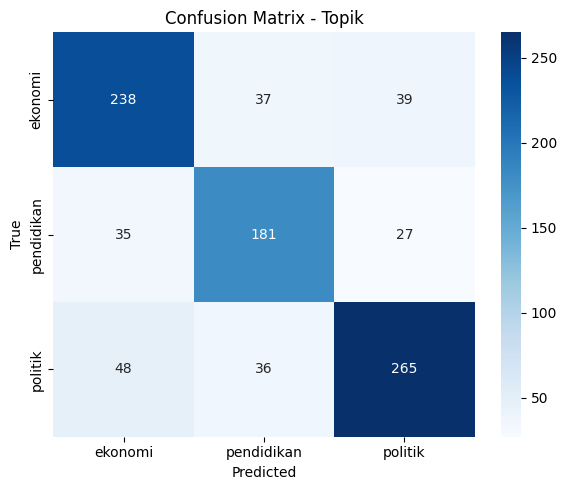

In [27]:
# Evaluasi Topik
evaluate_final_with_cm(
    model=model_topic,
    val_loader=val_loader_topic,
    label_names=topic_encoder.classes_,
    model_path="best_model_topic.pt",
    model_type="Topik"
)

EVALUASI MODEL: SENTIMEN

 Classification Report:

              precision    recall  f1-score   support

    negative       0.97      0.92      0.95       563
     neutral       0.96      0.98      0.97       564
    positive       0.96      0.98      0.97       564

    accuracy                           0.96      1691
   macro avg       0.96      0.96      0.96      1691
weighted avg       0.96      0.96      0.96      1691



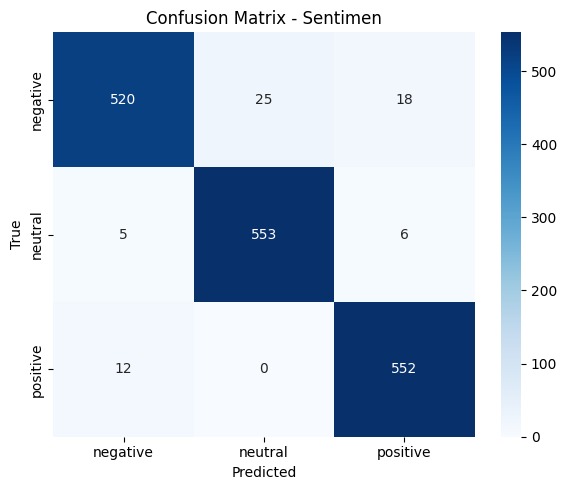

In [28]:
# Evaluasi sentimen
evaluate_final_with_cm(
    model=model_sentiment,
    val_loader=val_loader_sentiment,
    label_names=sentiment_encoder.classes_,
    model_path="best_model_sentiment.pt",
    model_type="Sentimen"
)

## **--- Uji Coba ---**

In [29]:
def predict_topic_and_sentiment(text):
    # Tokenisasi input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # --- Prediksi Topik ---
    model_topic.eval()
    with torch.no_grad():
        outputs_topic = model_topic(**inputs)
        logits_topic = outputs_topic.logits
        probs_topic = F.softmax(logits_topic, dim=1).cpu().numpy()[0]
        pred_id_topic = torch.argmax(logits_topic, dim=1).item()
        pred_label_topic = topic_encoder.inverse_transform([pred_id_topic])[0]

    # --- Prediksi Sentimen ---
    model_sentiment.eval()
    with torch.no_grad():
        outputs_sentiment = model_sentiment(**inputs)
        logits_sentiment = outputs_sentiment.logits
        probs_sentiment = F.softmax(logits_sentiment, dim=1).cpu().numpy()[0]
        pred_id_sentiment = torch.argmax(logits_sentiment, dim=1).item()
        pred_label_sentiment = sentiment_encoder.inverse_transform([pred_id_sentiment])[0]

    # --- Cetak hasil gabungan ---
    print("="*60)
    print(f"TEKS BARU:\n{text}")
    print(f"Model memprediksi sentimen *{pred_label_sentiment}* pada topik *{pred_label_topic}*")

    print("\nTOPIK TERPREDIKSI:")
    print(f"=> {pred_label_topic}")
    for label, prob in zip(topic_encoder.classes_, probs_topic):
        print(f"   {label:<10}: {prob*100:.2f}%")

    print("\nSENTIMEN TERPREDIKSI:")
    print(f"=> {pred_label_sentiment}")
    for label, prob in zip(sentiment_encoder.classes_, probs_sentiment):
        print(f"   {label:<10}: {prob*100:.2f}%")
    print("="*60)

    return {
        "text": text,
        "predicted_topic": pred_label_topic,
        "predicted_sentiment": pred_label_sentiment,
        "topic_probs": dict(zip(topic_encoder.classes_, probs_topic)),
        "sentiment_probs": dict(zip(sentiment_encoder.classes_, probs_sentiment))
    }

In [33]:
predict_topic_and_sentiment("presiden prabowo membuat indonesia menjadi negara yang banyak koruptonya")

TEKS BARU:
presiden prabowo membuat indonesia menjadi negara yang banyak koruptonya
Model memprediksi sentimen *negative* pada topik *politik*

TOPIK TERPREDIKSI:
=> politik
   ekonomi   : 9.75%
   pendidikan: 0.58%
   politik   : 89.67%

SENTIMEN TERPREDIKSI:
=> negative
   negative  : 99.61%
   neutral   : 0.37%
   positive  : 0.02%


{'text': 'presiden prabowo membuat indonesia menjadi negara yang banyak koruptonya',
 'predicted_topic': 'politik',
 'predicted_sentiment': 'negative',
 'topic_probs': {'ekonomi': np.float32(0.0975009),
  'pendidikan': np.float32(0.0058042128),
  'politik': np.float32(0.89669484)},
 'sentiment_probs': {'negative': np.float32(0.9961188),
  'neutral': np.float32(0.0036769242),
  'positive': np.float32(0.00020431193)}}

## **Menyimpan Model**

In [34]:
# Simpan model topik
model_topic.save_pretrained("./model_topic")
tokenizer.save_pretrained("./model_topic")

# Simpan model sentimen
model_sentiment.save_pretrained("./model_sentiment")
tokenizer.save_pretrained("./model_sentiment")

('./model_sentiment/tokenizer_config.json',
 './model_sentiment/special_tokens_map.json',
 './model_sentiment/vocab.txt',
 './model_sentiment/added_tokens.json',
 './model_sentiment/tokenizer.json')

In [35]:
import pickle
with open("topic_encoder.pkl", "wb") as f:
    pickle.dump(topic_encoder, f)

with open("sentiment_encoder.pkl", "wb") as f:
    pickle.dump(sentiment_encoder, f)

In [36]:
from google.colab import drive
drive.mount('/content/drive')

# Salin folder model_topic ke Google Drive
!cp -r model_topic /content/drive/MyDrive/

# Salin folder model_sentiment ke Google Drive
!cp -r model_sentiment /content/drive/MyDrive/

Mounted at /content/drive
